Scaling down `overall_rating` to 3-class and creates in `satisfaction_class`

In [1]:
import csv
import os

INPUT_CSV = "/content/drive/MyDrive/PR_Sky/Dataset/seat.csv"
OUT_DIR = "/content/drive/MyDrive/PR_Sky"
try:
    os.makedirs(OUT_DIR, exist_ok=True)
except:
    pass
OUT_CSV = OUT_DIR + "/seat_with_target.csv"

rows = []
with open(INPUT_CSV, "r", encoding="utf-8") as f:
    r = csv.DictReader(f)
    header = r.fieldnames
    for row in r:

        v = row.get("overall_rating", "")
        ok = True
        try:
            v2 = float(v)
        except:
            ok = False
        if ok:

            if v2 <= 4:
                sc = 0
            elif v2 <= 7:
                sc = 1
            else:
                sc = 2
            row["overall_rating"] = v2
            row["satisfaction_class"] = sc
            rows.append(row)

if "satisfaction_class" not in header:
    header = header + ["satisfaction_class"]

with open(OUT_CSV, "w", newline="", encoding="utf-8") as f:
    w = csv.DictWriter(f, fieldnames=header)
    w.writeheader()
    for row in rows:
        w.writerow(row)

row_count = len(rows)
col_count = len(header) if header else 0
print("Final dataset shape:", (row_count, col_count))

c0 = 0
c1 = 0
c2 = 0
for row in rows:
    sc = row["satisfaction_class"]
    if sc == 0:
        c0 += 1
    elif sc == 1:
        c1 += 1
    elif sc == 2:
        c2 += 1
total = c0 + c1 + c2
p0 = (c0 / total) if total > 0 else 0.0
p1 = (c1 / total) if total > 0 else 0.0
p2 = (c2 / total) if total > 0 else 0.0

print("Class distribution:\n", end="")
print("0", round(p0, 6))
print("1", round(p1, 6))
print("2", round(p2, 6))

print("Saved:", OUT_CSV)

Final dataset shape: (1257, 22)
Class distribution:
0 0.567224
1 0.198091
2 0.234686
Saved: /content/drive/MyDrive/PR_Sky/seat_with_target.csv


# Path way to Gaussian Naive Bayes

Load & sanity check

In [2]:
import csv

IN_CSV = "/content/drive/MyDrive/PR_Sky/seat_with_target.csv"
OUT_CSV = "/content/drive/MyDrive/PR_Sky/seat_with_target__checked.csv"

rows = []
with open(IN_CSV, "r", encoding="utf-8") as f:
    r = csv.DictReader(f)
    header = r.fieldnames
    for row in r:
        rows.append(row)

print("Shape:", (len(rows), len(header)))
print("Columns:", list(header))

has_target = "satisfaction_class" in header
if not has_target:
    raise ValueError("satisfaction_class not found. Create it from overall_rating before this step.")

clean_rows = []
for row in rows:
    v = row.get("satisfaction_class", "")
    ok = True
    try:
        vv = float(v)
        if vv == int(vv):
            vv = int(vv)
        else:
            ok = False
    except:
        ok = False
    if ok and (vv == 0 or vv == 1 or vv == 2):
        row["satisfaction_class"] = vv
        clean_rows.append(row)

if len(clean_rows) < len(rows):
    print("Warning: Found rows with invalid satisfaction_class; dropping them.")
rows = clean_rows

c0 = c1 = c2 = 0
for row in rows:
    cls = row["satisfaction_class"]
    if cls == 0:
        c0 += 1
    elif cls == 1:
        c1 += 1
    elif cls == 2:
        c2 += 1
total = c0 + c1 + c2

print("\nClass distribution (counts):")
print("0", c0)
print("1", c1)
print("2", c2)

print("\nClass distribution (proportions):")
if total > 0:
    print("0", round(c0 / total, 3))
    print("1", round(c1 / total, 3))
    print("2", round(c2 / total, 3))
else:
    print("0", 0.0); print("1", 0.0); print("2", 0.0)

numeric_feature_candidates = [
    "seat_legroom_rating",
    "seat_recline_rating",
    "seat_width_rating",
    "aisle_space_rating",
    "viewing_tv_rating",
    "power_supply_rating",
    "seat_storage_rating",
]

numeric_cols = [c for c in numeric_feature_candidates if c in header]
if len(numeric_cols) == 0:
    raise ValueError("No numeric rating features found. Check your dataset columns.")

for row in rows:
    for c in numeric_cols:
        txt = row.get(c, "")
        try:
            row[c] = float(txt)
        except:
            row[c] = None

print("\nNumeric features to use (excluding overall_rating):", numeric_cols)

miss_list = []
n = len(rows) if len(rows) > 0 else 1
for c in numeric_cols:
    miss_cnt = 0
    for row in rows:
        if row[c] is None:
            miss_cnt += 1
    miss_pct = miss_cnt / n
    miss_list.append((c, miss_pct))

miss_list.sort(key=lambda t: t[1], reverse=True)

print("\nMissingness (numeric features):")
for c, pct in miss_list:
    print(c, round(pct, 3))

high_missing = [c for c, pct in miss_list if pct > 0.5]
if len(high_missing) > 0:
    print("\nNOTE: These features have >50% missing values and may hurt GNB:")
    print(high_missing)
    print("You can drop them or keep with imputation + missingness flags in preprocessing.")

print("\nSample rows (head):")
show_cols = ["satisfaction_class"] + numeric_cols
print(show_cols)
for i, row in enumerate(rows[:10]):
    one = []
    for c in show_cols:
        v = row.get(c, "")
        if v is None:
            one.append("")
        else:
            one.append(v)
    print(one)

with open(OUT_CSV, "w", newline="", encoding="utf-8") as f:
    w = csv.DictWriter(f, fieldnames=header)
    w.writeheader()
    for row in rows:
        out_row = {}
        for col in header:
            v = row.get(col, "")
            if v is None:
                v = ""
            out_row[col] = v
        w.writerow(out_row)

print("\nSaved checked dataset to:", OUT_CSV)

Shape: (1257, 22)
Columns: ['airline_name', 'link', 'title', 'author', 'author_country', 'date', 'content', 'aircraft', 'seat_layout', 'date_flown', 'cabin_flown', 'type_traveller', 'overall_rating', 'seat_legroom_rating', 'seat_recline_rating', 'seat_width_rating', 'aisle_space_rating', 'viewing_tv_rating', 'power_supply_rating', 'seat_storage_rating', 'recommended', 'satisfaction_class']

Class distribution (counts):
0 713
1 249
2 295

Class distribution (proportions):
0 0.567
1 0.198
2 0.235

Numeric features to use (excluding overall_rating): ['seat_legroom_rating', 'seat_recline_rating', 'seat_width_rating', 'aisle_space_rating', 'viewing_tv_rating', 'power_supply_rating', 'seat_storage_rating']

Missingness (numeric features):
power_supply_rating 0.951
seat_storage_rating 0.91
viewing_tv_rating 0.023
seat_legroom_rating 0.0
seat_recline_rating 0.0
seat_width_rating 0.0
aisle_space_rating 0.0

NOTE: These features have >50% missing values and may hurt GNB:
['power_supply_rating', 

Preprocessing & Feature Engineering

In [3]:
import os
import csv
import random

IN_CSV = "/content/drive/MyDrive/PR_Sky/seat_with_target__checked.csv"
OUT_DIR = "/content/drive/MyDrive/PR_Sky/"
try:
    os.makedirs(OUT_DIR, exist_ok=True)
except:
    pass

train_path = OUT_DIR + "seat_train_proc.csv"
test_path  = OUT_DIR + "seat_test_proc.csv"

rows = []
with open(IN_CSV, "r", encoding="utf-8") as f:
    r = csv.DictReader(f)
    header = r.fieldnames
    for row in r:
        rows.append(row)

target = "satisfaction_class"
features = [
    "seat_legroom_rating",
    "seat_recline_rating",
    "seat_width_rating",
    "aisle_space_rating",
    "viewing_tv_rating"
]

clean = []
for row in rows:
    v = row.get(target, "")
    ok = True
    try:
        v2 = float(v)
        if v2 == int(v2):
            v2 = int(v2)
        else:
            ok = False
    except:
        ok = False
    if ok and (v2 == 0 or v2 == 1 or v2 == 2):
        row[target] = v2
        clean.append(row)
rows = clean

for row in rows:
    for c in features:
        try:
            row[c] = float(row.get(c, ""))
        except:
            row[c] = None

c0 = c1 = c2 = 0
for row in rows:
    if row[target] == 0:
        c0 += 1
    elif row[target] == 1:
        c1 += 1
    elif row[target] == 2:
        c2 += 1
total = c0 + c1 + c2

print("\nClass distribution (counts):")
print("0", c0)
print("1", c1)
print("2", c2)

print("\nClass distribution (proportions):")
if total > 0:
    print("0", round(c0 / total, 3))
    print("1", round(c1 / total, 3))
    print("2", round(c2 / total, 3))
else:
    print("0", 0.0)
    print("1", 0.0)
    print("2", 0.0)

idx0 = []; idx1 = []; idx2 = []
for i in range(len(rows)):
    yv = rows[i][target]
    if yv == 0:
        idx0.append(i)
    elif yv == 1:
        idx1.append(i)
    elif yv == 2:
        idx2.append(i)

random.seed(42)
random.shuffle(idx0); random.shuffle(idx1); random.shuffle(idx2)

def split_idx(lst):
    n = len(lst)
    n_test = int(n * 0.20)
    te = lst[:n_test]
    tr = lst[n_test:]
    return tr, te

tr0, te0 = split_idx(idx0)
tr1, te1 = split_idx(idx1)
tr2, te2 = split_idx(idx2)

train_idx = tr0 + tr1 + tr2
test_idx  = te0 + te1 + te2

train_rows = [rows[i] for i in train_idx]
test_rows  = [rows[i] for i in test_idx]

medians = {}
for c in features:
    vals = []
    for row in train_rows:
        v = row[c]
        if v is not None:
            vals.append(v)
    vals.sort()
    if len(vals) == 0:
        med = 0.0
    else:
        n = len(vals)
        mid = n // 2
        if n % 2 == 1:
            med = vals[mid]
        else:
            med = (vals[mid - 1] + vals[mid]) / 2.0
    medians[c] = med

for row in train_rows:
    for c in features:
        if row[c] is None:
            row[c] = medians[c]

for row in test_rows:
    for c in features:
        if row[c] is None:
            row[c] = medians[c]

print("\nShapes: X_train:", (len(train_rows), len(features)), "X_test:", (len(test_rows), len(features)))

with open(train_path, "w", newline="", encoding="utf-8") as f:
    cols = features + [target]
    w = csv.DictWriter(f, fieldnames=cols)
    w.writeheader()
    for row in train_rows:
        out_row = {}
        for c in cols:
            out_row[c] = row[c]
        w.writerow(out_row)

with open(test_path, "w", newline="", encoding="utf-8") as f:
    cols = features + [target]
    w = csv.DictWriter(f, fieldnames=cols)
    w.writeheader()
    for row in test_rows:
        out_row = {}
        for c in cols:
            out_row[c] = row[c]
        w.writerow(out_row)

print("\nSaved preprocessed datasets:")
print(" - Train:", train_path)
print(" - Test :", test_path)


Class distribution (counts):
0 713
1 249
2 295

Class distribution (proportions):
0 0.567
1 0.198
2 0.235

Shapes: X_train: (1007, 5) X_test: (250, 5)

Saved preprocessed datasets:
 - Train: /content/drive/MyDrive/PR_Sky/seat_train_proc.csv
 - Test : /content/drive/MyDrive/PR_Sky/seat_test_proc.csv


Gaussian Naive Bayes

Train shape: (1007, 5)  Test shape: (250, 5)
Classes in y_train: [0, 1, 2]
Classes in y_test : [0, 1, 2]

=== GaussianNB Metrics (Test) ===
Accuracy          : 0.8120
Macro F1          : 0.7682
Log-loss          : 0.5288
Brier (multiclass): 0.283319

=== Classification Report ===
              precision    recall  f1-score   support
           0      0.9313    0.8592     0.8938       142
           1      0.5172    0.6122     0.5607        49
           2      0.8361    0.8644     0.8500        59

    accuracy                             0.8120       250
   macro avg      0.7615    0.7786     0.7682       250
weighted avg      0.8277    0.8120     0.8182       250

Confusion Matrix (counts) [rows=true, cols=pred]:
 [[122  20   0]
 [  9  30  10]
 [  0   8  51]]


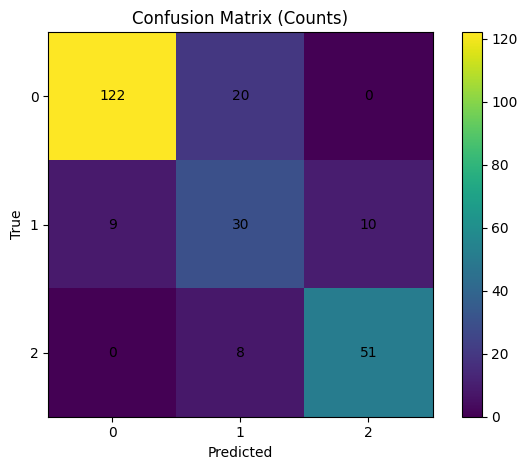

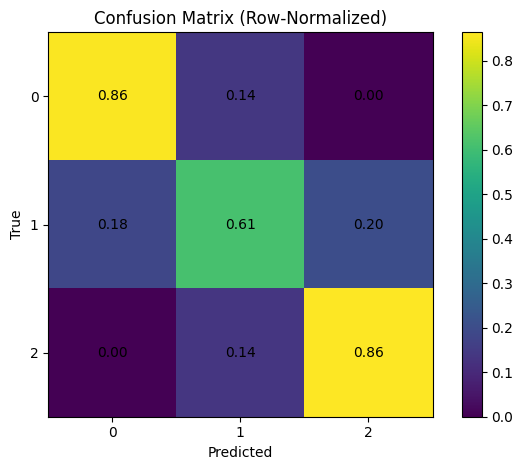

In [4]:
import os
import csv
import math
import numpy as np
import matplotlib.pyplot as plt

BASE_DIR = "/content/drive/MyDrive/PR_Sky"
TRAIN_CSV = os.path.join(BASE_DIR, "seat_train_proc.csv")
TEST_CSV  = os.path.join(BASE_DIR, "seat_test_proc.csv")

train_rows = []
with open(TRAIN_CSV, "r", encoding="utf-8") as f:
    r = csv.DictReader(f)
    train_header = r.fieldnames
    for row in r:
        train_rows.append(row)

test_rows = []
with open(TEST_CSV, "r", encoding="utf-8") as f:
    r = csv.DictReader(f)
    test_header = r.fieldnames
    for row in r:
        test_rows.append(row)

target_col = "satisfaction_class"

features = []
i = 0
while i < len(train_header):
    c = train_header[i]
    if c != target_col:
        features.append(c)
    i = i + 1

X_train = []
y_train = []
i = 0
while i < len(train_rows):
    row = train_rows[i]
    vec = []
    j = 0
    while j < len(features):
        try:
            vec.append(float(row[features[j]]))
        except:
            vec.append(0.0)
        j = j + 1
    X_train.append(vec)
    y_train.append(int(float(row[target_col])))
    i = i + 1

X_test = []
y_test = []
i = 0
while i < len(test_rows):
    row = test_rows[i]
    vec = []
    j = 0
    while j < len(features):
        try:
            vec.append(float(row[features[j]]))
        except:
            vec.append(0.0)
        j = j + 1
    X_test.append(vec)
    y_test.append(int(float(row[target_col])))
    i = i + 1

X_train = np.array(X_train, dtype=float)
y_train = np.array(y_train, dtype=int)
X_test  = np.array(X_test, dtype=float)
y_test  = np.array(y_test, dtype=int)

print("Train shape:", (X_train.shape[0], X_train.shape[1]), " Test shape:", (X_test.shape[0], X_test.shape[1]))

seen_train = {}
seen_test = {}
i = 0
while i < len(y_train):
    seen_train[y_train[i]] = True
    i = i + 1
i = 0
while i < len(y_test):
    seen_test[y_test[i]] = True
    i = i + 1
y_train_classes = []
y_test_classes = []
for k in [0,1,2]:
    if k in seen_train:
        y_train_classes.append(k)
    if k in seen_test:
        y_test_classes.append(k)
print("Classes in y_train:", y_train_classes)
print("Classes in y_test :", y_test_classes)

classes = [0,1,2]

by_class_idx = {0:[],1:[],2:[]}
i = 0
while i < len(y_train):
    c = y_train[i]
    if c in by_class_idx:
        by_class_idx[c].append(i)
    i = i + 1

priors = {0:0.0,1:0.0,2:0.0}
n_total = float(len(y_train)) if len(y_train) > 0 else 1.0
priors[0] = len(by_class_idx[0]) / n_total
priors[1] = len(by_class_idx[1]) / n_total
priors[2] = len(by_class_idx[2]) / n_total

means = {0:[],1:[],2:[]}
vars_ = {0:[],1:[],2:[]}

cix = 0
while cix < 3:
    c = classes[cix]
    j = 0
    while j < X_train.shape[1]:
        s = 0.0
        cnt = 0
        k = 0
        while k < len(by_class_idx[c]):
            idx = by_class_idx[c][k]
            s += X_train[idx, j]
            cnt += 1
            k += 1
        mu = s / cnt if cnt > 0 else 0.0
        means[c].append(mu)

        s2 = 0.0
        k = 0
        while k < len(by_class_idx[c]):
            idx = by_class_idx[c][k]
            d = X_train[idx, j] - mu
            s2 += d*d
            k += 1
        var = (s2 / cnt) if cnt > 0 else 1e-6
        if var <= 1e-9:
            var = 1e-9
        vars_[c].append(var)
        j += 1
    cix += 1

y_pred = []
y_proba = []
i = 0
while i < X_test.shape[0]:

    logp = {}
    cix = 0
    while cix < 3:
        c = classes[cix]
        pr = priors[c]
        if pr <= 0.0:
            pr = 1e-12
        lp = math.log(pr)
        j = 0
        while j < X_test.shape[1]:
            x = X_test[i, j]
            mu = means[c][j]
            var = vars_[c][j]
            lp = lp - 0.5*math.log(2.0*math.pi*var) - ((x-mu)*(x-mu))/(2.0*var)
            j += 1
        logp[c] = lp
        cix += 1

    mx = max(logp[0], logp[1], logp[2])
    e0 = math.exp(logp[0]-mx)
    e1 = math.exp(logp[1]-mx)
    e2 = math.exp(logp[2]-mx)
    s = e0 + e1 + e2
    if s == 0.0:
        p0 = p1 = p2 = 1.0/3.0
    else:
        p0 = e0/s; p1 = e1/s; p2 = e2/s
    y_proba.append([p0,p1,p2])

    if p0 >= p1 and p0 >= p2:
        y_pred.append(0)
    elif p1 >= p0 and p1 >= p2:
        y_pred.append(1)
    else:
        y_pred.append(2)
    i += 1

y_pred = np.array(y_pred, dtype=int)
y_proba = np.array(y_proba, dtype=float)
classes_arr = np.array(classes, dtype=int)

correct = 0
i = 0
while i < len(y_test):
    if y_test[i] == y_pred[i]:
        correct += 1
    i += 1
acc = (correct / float(len(y_test))) if len(y_test) > 0 else 0.0

cm = [[0,0,0],[0,0,0],[0,0,0]]
i = 0
while i < len(y_test):
    a = y_test[i]; b = y_pred[i]
    if 0 <= a <= 2 and 0 <= b <= 2:
        cm[a][b] += 1
    i += 1

f1s = []
c = 0
while c < 3:
    tp = cm[c][c]
    col_sum = cm[0][c] + cm[1][c] + cm[2][c]
    row_sum = cm[c][0] + cm[c][1] + cm[c][2]
    fp = col_sum - tp
    fn = row_sum - tp
    if tp + fp > 0:
        prec = tp / float(tp + fp)
    else:
        prec = 0.0
    if tp + fn > 0:
        rec = tp / float(tp + fn)
    else:
        rec = 0.0
    if prec + rec > 0:
        f1c = 2.0 * prec * rec / (prec + rec)
    else:
        f1c = 0.0
    f1s.append(f1c)
    c += 1
f1_macro = (f1s[0] + f1s[1] + f1s[2]) / 3.0

eps = 1e-15
ll_sum = 0.0
i = 0
while i < len(y_test):
    t = y_test[i]
    p = y_proba[i, t]
    if p < eps:
        p = eps
    ll_sum += -math.log(p)
    i += 1
ll = (ll_sum / float(len(y_test))) if len(y_test) > 0 else 0.0

brier_sum = 0.0
i = 0
while i < len(y_test):
    t = y_test[i]
    y0 = 1.0 if t == 0 else 0.0
    y1 = 1.0 if t == 1 else 0.0
    y2 = 1.0 if t == 2 else 0.0
    p0, p1, p2 = y_proba[i,0], y_proba[i,1], y_proba[i,2]
    brier_sum += (p0-y0)*(p0-y0) + (p1-y1)*(p1-y1) + (p2-y2)*(p2-y2)
    i += 1
brier_multiclass = (brier_sum / float(len(y_test))) if len(y_test) > 0 else 0.0

print("\n=== GaussianNB Metrics (Test) ===")
print("Accuracy          : %.4f" % acc)
print("Macro F1          : %.4f" % f1_macro)
print("Log-loss          : %.4f" % ll)
print("Brier (multiclass): %.6f" % brier_multiclass)

print("\n=== Classification Report ===")
print("              precision    recall  f1-score   support")
c = 0
total_support = 0
macro_p = 0.0
macro_r = 0.0
while c < 3:
    tp = cm[c][c]
    col_sum = cm[0][c] + cm[1][c] + cm[2][c]
    row_sum = cm[c][0] + cm[c][1] + cm[c][2]
    fp = col_sum - tp
    fn = row_sum - tp
    total_support += row_sum
    if tp + fp > 0:
        prec = tp / float(tp + fp)
    else:
        prec = 0.0
    if tp + fn > 0:
        rec = tp / float(tp + fn)
    else:
        rec = 0.0
    macro_p += prec
    macro_r += rec
    if prec + rec > 0:
        f1c = 2.0 * prec * rec / (prec + rec)
    else:
        f1c = 0.0
    print("{:>12} {:>11.4f} {:>9.4f} {:>10.4f} {:>9d}".format(str(c), prec, rec, f1c, row_sum))
    c += 1
macro_p /= 3.0
macro_r /= 3.0

w_prec = 0.0; w_rec = 0.0; w_f1 = 0.0
c = 0
while c < 3:
    row_sum = cm[c][0] + cm[c][1] + cm[c][2]

    tp = cm[c][c]
    col_sum = cm[0][c] + cm[1][c] + cm[2][c]
    fp = col_sum - tp
    fn = row_sum - tp
    if tp + fp > 0:
        prec = tp / float(tp + fp)
    else:
        prec = 0.0
    if tp + fn > 0:
        rec = tp / float(tp + fn)
    else:
        rec = 0.0
    if prec + rec > 0:
        f1c = 2.0 * prec * rec / (prec + rec)
    else:
        f1c = 0.0
    w_prec += prec * row_sum
    w_rec  += rec  * row_sum
    w_f1   += f1c * row_sum
    c += 1
if total_support > 0:
    w_prec /= total_support
    w_rec  /= total_support
    w_f1   /= total_support
print("\n{:>12} {:>34.4f} {:>9d}".format("accuracy", acc, total_support))
print("{:>12} {:>11.4f} {:>9.4f} {:>10.4f} {:>9d}".format("macro avg", macro_p, macro_r, f1_macro, total_support))
print("{:>12} {:>11.4f} {:>9.4f} {:>10.4f} {:>9d}".format("weighted avg", w_prec, w_rec, w_f1, total_support))

cm_np = np.array(cm)
print("\nConfusion Matrix (counts) [rows=true, cols=pred]:\n", cm_np)

plt.figure()
plt.imshow(cm_np, interpolation='nearest')
plt.title("Confusion Matrix (Counts)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(range(len(classes_arr)), classes_arr)
plt.yticks(range(len(classes_arr)), classes_arr)
i = 0
while i < cm_np.shape[0]:
    j = 0
    while j < cm_np.shape[1]:
        plt.text(j, i, str(cm_np[i, j]), ha="center", va="center")
        j += 1
    i += 1
plt.colorbar()
plt.tight_layout()
plt.show()

cmn = np.zeros_like(cm_np, dtype=float)
i = 0
while i < cm_np.shape[0]:
    s = cm_np[i].sum()
    if s == 0:
        cmn[i] = [0.0, 0.0, 0.0]
    else:
        cmn[i] = cm_np[i] / float(s)
    i += 1

plt.figure()
plt.imshow(cmn, interpolation='nearest')
plt.title("Confusion Matrix (Row-Normalized)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(range(len(classes_arr)), classes_arr)
plt.yticks(range(len(classes_arr)), classes_arr)
i = 0
while i < cmn.shape[0]:
    j = 0
    while j < cmn.shape[1]:
        plt.text(j, i, "%.2f" % (cmn[i, j]), ha="center", va="center")
        j += 1
    i += 1
plt.colorbar()
plt.tight_layout()
plt.show()

# Path way to Multinomial Naive Bayes

Load & Target Check

In [5]:
import csv

IN_CSV = "/content/drive/MyDrive/PR_Sky/seat_with_target__checked.csv"
OUT_CSV = "/content/drive/MyDrive/PR_Sky/seat_with_target__text_checked.csv"

rows = []
with open(IN_CSV, "r", encoding="utf-8") as f:
    r = csv.DictReader(f)
    header = r.fieldnames
    for row in r:
        rows.append(row)

print("=== Shape of dataset ===")
print((len(rows), len(header)))

print("\n=== Columns available ===")
print(list(header))

if "satisfaction_class" not in header:
    raise ValueError("Target column 'satisfaction_class' is missing! Please create it first.")

valid_rows = []
invalid_count = 0
for row in rows:
    v = row.get("satisfaction_class", "")
    ok = True
    try:
        vv = float(v)
        if vv == int(vv):
            vv = int(vv)
        else:
            ok = False
    except:
        ok = False
    if ok and (vv == 0 or vv == 1 or vv == 2):
        row["satisfaction_class"] = vv
        valid_rows.append(row)
    else:
        invalid_count += 1

if invalid_count > 0:
    print("\nDropping rows with invalid target values:", invalid_count)
rows = valid_rows

c0 = c1 = c2 = 0
for row in rows:
    y = row["satisfaction_class"]
    if y == 0:
        c0 += 1
    elif y == 1:
        c1 += 1
    elif y == 2:
        c2 += 1
total = c0 + c1 + c2 if (c0 + c1 + c2) > 0 else 1

print("\n=== Class distribution (counts) ===")
print("0", c0)
print("1", c1)
print("2", c2)

print("\n=== Class distribution (proportions) ===")
print("0", round(c0 / total, 3))
print("1", round(c1 / total, 3))
print("2", round(c2 / total, 3))

if "content" not in header:
    raise ValueError("Column 'content' not found in dataset!")

before_rows = len(rows)
clean_rows = []
for row in rows:
    txt = row.get("content", "")
    txt = "" if txt is None else str(txt).strip()
    if txt != "":
        row["content"] = txt
        clean_rows.append(row)
rows = clean_rows
after_rows = len(rows)

print(f"\nDropped {before_rows - after_rows} rows due to empty 'content'.")
print("Remaining rows:", after_rows)

print("\n=== Sample reviews (content + satisfaction_class) ===")
print(["satisfaction_class", "content"])
for row in rows[:10]:
    print([row["satisfaction_class"], row.get("content", "")])

with open(OUT_CSV, "w", newline="", encoding="utf-8") as f:
    w = csv.DictWriter(f, fieldnames=header)
    w.writeheader()
    for row in rows:
        out_row = {}
        for col in header:
            out_row[col] = row.get(col, "")
        w.writerow(out_row)

print("\nSaved cleaned text dataset to:", OUT_CSV)

=== Shape of dataset ===
(1257, 22)

=== Columns available ===
['airline_name', 'link', 'title', 'author', 'author_country', 'date', 'content', 'aircraft', 'seat_layout', 'date_flown', 'cabin_flown', 'type_traveller', 'overall_rating', 'seat_legroom_rating', 'seat_recline_rating', 'seat_width_rating', 'aisle_space_rating', 'viewing_tv_rating', 'power_supply_rating', 'seat_storage_rating', 'recommended', 'satisfaction_class']

=== Class distribution (counts) ===
0 713
1 249
2 295

=== Class distribution (proportions) ===
0 0.567
1 0.198
2 0.235

Dropped 0 rows due to empty 'content'.
Remaining rows: 1257

=== Sample reviews (content + satisfaction_class) ===
['satisfaction_class', 'content']
[2, 'LHR to Larnaca return. Plane was clean and in good condition. Drinks were served throughout both flights. Food was good. Would definitely not hesitate to use this airline for European trips.']
[2, 'For a short haul airline the seats are very good. I find the seats comfortable and plenty of leg 

Text preprocessing → Train/Test split → Word2Vec

In [6]:
!pip install gensim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 91.5 MB/s eta 0:00:00


In [7]:
import os
import re
import csv
import math
import random
import numpy as np
from gensim.models import Word2Vec
from sklearn.cluster import MiniBatchKMeans

BASE   = "/content/drive/MyDrive/PR_Sky"
IN_CSV = BASE + "/seat_with_target__text_checked.csv"
try:
    os.makedirs(BASE, exist_ok=True)
except:
    pass

rows = []
with open(IN_CSV, "r", encoding="utf-8") as f:
    r = csv.DictReader(f)
    header = r.fieldnames
    for row in r:
        rows.append(row)

target_col = "satisfaction_class"
text_col   = "content"
if target_col not in header or text_col not in header:
    raise SystemExit(0)

token_pat = re.compile(r"[A-Za-z0-9]+")
def tokenize(s):
    return token_pat.findall(str(s).lower())

X_text = []
y = []
i = 0
while i < len(rows):
    X_text.append(str(rows[i][text_col]))
    y.append(int(float(rows[i][target_col])))
    i = i + 1

idx0 = []; idx1 = []; idx2 = []
i = 0
while i < len(y):
    if y[i] == 0:
        idx0.append(i)
    elif y[i] == 1:
        idx1.append(i)
    elif y[i] == 2:
        idx2.append(i)
    i = i + 1

random.seed(42)
random.shuffle(idx0); random.shuffle(idx1); random.shuffle(idx2)

def split_idx(lst):
    n = len(lst)
    n_test = int(n * 0.20)
    return lst[n_test:], lst[:n_test]

tr0, te0 = split_idx(idx0)
tr1, te1 = split_idx(idx1)
tr2, te2 = split_idx(idx2)

train_idx = tr0 + tr1 + tr2
test_idx  = te0 + te1 + te2

X_train_text = [X_text[i] for i in train_idx]
X_test_text  = [X_text[i] for i in test_idx]
y_train = [y[i] for i in train_idx]
y_test  = [y[i] for i in test_idx]

print("Train size:", len(X_train_text), " Test size:", len(X_test_text))

c0 = c1 = c2 = 0
for v in y_train:
    if v == 0: c0 += 1
    elif v == 1: c1 += 1
    elif v == 2: c2 += 1
print("Class counts (train):")
print("0", c0)
print("1", c1)
print("2", c2)

c0 = c1 = c2 = 0
for v in y_test:
    if v == 0: c0 += 1
    elif v == 1: c1 += 1
    elif v == 2: c2 += 1
print("Class counts (test):")
print("0", c0)
print("1", c1)
print("2", c2)

with open(BASE + "/seat_text_train_split.csv", "w", newline="", encoding="utf-8") as f:
    w = csv.writer(f)
    w.writerow([text_col, target_col])
    i = 0
    while i < len(X_train_text):
        w.writerow([X_train_text[i], y_train[i]])
        i = i + 1

with open(BASE + "/seat_text_test_split.csv", "w", newline="", encoding="utf-8") as f:
    w = csv.writer(f)
    w.writerow([text_col, target_col])
    i = 0
    while i < len(X_test_text):
        w.writerow([X_test_text[i], y_test[i]])
        i = i + 1

with open(BASE + "/y_train.csv", "w", newline="", encoding="utf-8") as f:
    w = csv.writer(f)
    w.writerow([target_col])
    for v in y_train:
        w.writerow([v])

with open(BASE + "/y_test.csv", "w", newline="", encoding="utf-8") as f:
    w = csv.writer(f)
    w.writerow([target_col])
    for v in y_test:
        w.writerow([v])

tr_tokens = []
i = 0
while i < len(X_train_text):
    tr_tokens.append(tokenize(X_train_text[i]))
    i = i + 1

te_tokens = []
i = 0
while i < len(X_test_text):
    te_tokens.append(tokenize(X_test_text[i]))
    i = i + 1

w2v = Word2Vec(
    sentences=tr_tokens,
    vector_size=200,
    window=5,
    min_count=2,
    workers=4,
    sg=0,
    negative=10,
    epochs=10,
    seed=42
)

vocab_words = []
i = 0
while i < len(w2v.wv.key_to_index.keys()):

    if i == 0:
        all_keys = list(w2v.wv.key_to_index.keys())
    vocab_words.append(all_keys[i])
    i = i + 1

if len(vocab_words) == 0:
    raise RuntimeError("Word2Vec vocab is empty; check min_count or training data.")

W = w2v.wv[vocab_words]
V = W.shape[0]
dim = W.shape[1]

K = int(max(100, min(500, math.ceil(math.sqrt(V) * 2))))
print(f"Word2Vec vocab size: {V}  dim: {dim}  -> Clustering K={K}")

kmeans = MiniBatchKMeans(n_clusters=K, batch_size=2048, random_state=42, n_init=10)
kmeans.fit(W)

word_to_cluster = {}
i = 0
while i < len(vocab_words):
    word_to_cluster[vocab_words[i]] = int(kmeans.labels_[i])
    i = i + 1

def docs_to_boc_dense(docs_tokens, word2clust, K):
    n = len(docs_tokens)
    M = np.zeros((n, K), dtype=np.float32)
    i = 0
    while i < n:
        toks = docs_tokens[i]
        j = 0
        while j < len(toks):
            t = toks[j]
            cid = word2clust.get(t, None)
            if cid is not None:
                M[i, cid] = M[i, cid] + 1.0
            j = j + 1
        i = i + 1
    return M

X_train_boc = docs_to_boc_dense(tr_tokens, word_to_cluster, K)
X_test_boc  = docs_to_boc_dense(te_tokens, word_to_cluster, K)

print("BoC shapes -> Train:", X_train_boc.shape, " Test:", X_test_boc.shape)

train_cols = []
i = 0
while i < K:
    train_cols.append("cluster_" + str(i))
    i = i + 1

with open(BASE + "/X_train_boc.csv", "w", newline="", encoding="utf-8") as f:
    w = csv.writer(f)
    w.writerow(train_cols)
    i = 0
    while i < X_train_boc.shape[0]:
        w.writerow(list(X_train_boc[i]))
        i = i + 1

with open(BASE + "/X_test_boc.csv", "w", newline="", encoding="utf-8") as f:
    w = csv.writer(f)
    w.writerow(train_cols)
    i = 0
    while i < X_test_boc.shape[0]:
        w.writerow(list(X_test_boc[i]))
        i = i + 1

print("\nSaved CSVs:")
print(" - seat_text_train_split.csv / seat_text_test_split.csv")
print(" - y_train.csv / y_test.csv")
print(" - X_train_boc.csv / X_test_boc.csv")

Train size: 1007  Test size: 250
Class counts (train):
0 571
1 200
2 236
Class counts (test):
0 142
1 49
2 59
Word2Vec vocab size: 3021  dim: 200  -> Clustering K=110
BoC shapes -> Train: (1007, 110)  Test: (250, 110)

Saved CSVs:
 - seat_text_train_split.csv / seat_text_test_split.csv
 - y_train.csv / y_test.csv
 - X_train_boc.csv / X_test_boc.csv


Multinomial Naive Bayes

Train BoC shape: (1007, 110)  Test BoC shape: (250, 110)

=== Grid Search (neg_log_loss higher is better) ===
{'alpha': 0.05} -> -1.2883 (± 0.2014)
{'alpha': 0.1} -> -1.2878 (± 0.2011)
{'alpha': 0.5} -> -1.2841 (± 0.1988)
{'alpha': 1.0} -> -1.2799 (± 0.1964)
{'alpha': 2.0} -> -1.2728 (± 0.1921)
Best params: {'alpha': 2.0}

=== MultinomialNB (Word2Vec BoC) — Test Metrics ===
Accuracy : 0.5760
Macro F1 : 0.4918
Log-loss : 1.3053
Brier    : 0.207728

Classification Report:
              precision    recall  f1-score   support

           0     0.7133    0.7183    0.7158       142
           1     0.3256    0.2857    0.3043        49
           2     0.4375    0.4746    0.4553        59

    accuracy                         0.5760       250
   macro avg     0.4921    0.4929    0.4918       250
weighted avg     0.5722    0.5760    0.5737       250


Confusion Matrix (counts) [rows=true, cols=pred]:
 [[102  17  23]
 [ 22  14  13]
 [ 19  12  28]]


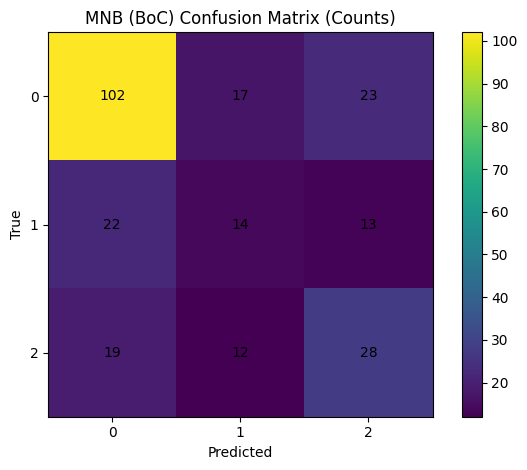

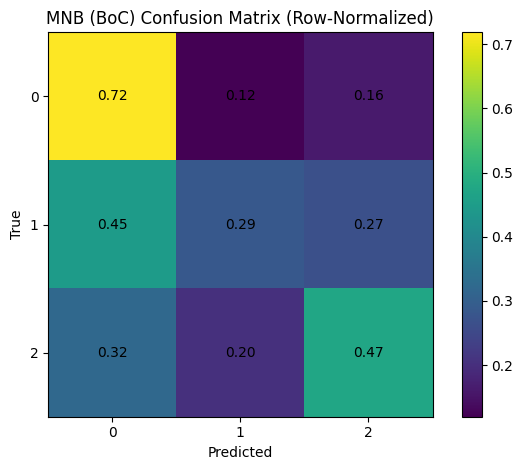


Top 15 clusters for class 0:
  cluster_40    log_prob=-2.527
  cluster_55    log_prob=-2.796
  cluster_27    log_prob=-2.968
  cluster_97    log_prob=-3.146
  cluster_66    log_prob=-3.242
  cluster_96    log_prob=-3.264
  cluster_14    log_prob=-3.270
  cluster_107   log_prob=-3.361
  cluster_4     log_prob=-3.394
  cluster_83    log_prob=-3.467
  cluster_43    log_prob=-3.646
  cluster_22    log_prob=-3.674
  cluster_49    log_prob=-3.775
  cluster_45    log_prob=-3.975
  cluster_56    log_prob=-4.015

Top 15 clusters for class 1:
  cluster_40    log_prob=-2.401
  cluster_55    log_prob=-2.736
  cluster_14    log_prob=-2.976
  cluster_66    log_prob=-3.078
  cluster_27    log_prob=-3.136
  cluster_96    log_prob=-3.206
  cluster_4     log_prob=-3.298
  cluster_43    log_prob=-3.423
  cluster_107   log_prob=-3.447
  cluster_97    log_prob=-3.543
  cluster_83    log_prob=-3.825
  cluster_49    log_prob=-3.842
  cluster_19    log_prob=-3.865
  cluster_22    log_prob=-3.894
  cluster_94

In [8]:
import os
import csv
import math
import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, f1_score, log_loss, confusion_matrix, classification_report

BASE = "/content/drive/MyDrive/PR_Sky"

def load_matrix(path):
    data = []
    with open(path, "r", encoding="utf-8") as f:
        r = csv.reader(f)
        header = next(r)
        for row in r:
            data.append([float(x) for x in row])
    return np.array(data, dtype=np.float32)

def load_vector(path):
    ys = []
    with open(path, "r", encoding="utf-8") as f:
        r = csv.reader(f)
        _ = next(r)
        for row in r:
            ys.append(int(row[0]))
    return np.array(ys, dtype=int)

X_train = load_matrix(os.path.join(BASE, "X_train_boc.csv"))
X_test  = load_matrix(os.path.join(BASE, "X_test_boc.csv"))
y_train = load_vector(os.path.join(BASE, "y_train.csv"))
y_test  = load_vector(os.path.join(BASE, "y_test.csv"))

print("Train BoC shape:", X_train.shape, " Test BoC shape:", X_test.shape)

n_splits = 5
classes = sorted(list(set(y_train.tolist())))
by_class = {c: [] for c in classes}
for i, y in enumerate(y_train):
    by_class[y].append(i)

folds = [list() for _ in range(n_splits)]
for c in classes:
    idxs = by_class[c]

    k = 0
    for ix in idxs:
        folds[k % n_splits].append(ix)
        k += 1

param_grid = [0.05, 0.1, 0.5, 1.0, 2.0]
best_alpha = None
best_score = None
best_model = None

print("\n=== Grid Search (neg_log_loss higher is better) ===")
for a in param_grid:
    scores = []

    for fi in range(n_splits):
        val_idx = folds[fi]
        train_idx = []
        for fj in range(n_splits):
            if fj != fi:
                train_idx.extend(folds[fj])

        Xt = X_train[train_idx]
        yt = y_train[train_idx]
        Xv = X_train[val_idx]
        yv = y_train[val_idx]

        clf = MultinomialNB(alpha=a)
        clf.fit(Xt, yt)
        proba = clf.predict_proba(Xv)
        ll = log_loss(yv, proba, labels=clf.classes_)
        scores.append(-ll)

    mean_score = float(np.mean(scores)) if len(scores) > 0 else float("-inf")
    std_score  = float(np.std(scores))  if len(scores) > 0 else 0.0
    print(f"{{'alpha': {a}}} -> {mean_score:.4f} (± {std_score:.4f})")

    if (best_score is None) or (mean_score > best_score):
        best_score = mean_score
        best_alpha = a

best_mnb = MultinomialNB(alpha=best_alpha)
best_mnb.fit(X_train, y_train)
print("Best params:", {"alpha": best_alpha})

y_pred  = best_mnb.predict(X_test)
y_proba = best_mnb.predict_proba(X_test)

acc = accuracy_score(y_test, y_pred)
f1m = f1_score(y_test, y_pred, average="macro")
ll  = log_loss(y_test, y_proba, labels=best_mnb.classes_)

Y = np.zeros_like(y_proba)
cls_to_idx = {c: i for i, c in enumerate(best_mnb.classes_)}
for i, yi in enumerate(y_test):
    Y[i, cls_to_idx[yi]] = 1.0
brier = float(np.mean((y_proba - Y) ** 2))

print("\n=== MultinomialNB (Word2Vec BoC) — Test Metrics ===")
print(f"Accuracy : {acc:.4f}")
print(f"Macro F1 : {f1m:.4f}")
print(f"Log-loss : {ll:.4f}")
print(f"Brier    : {brier:.6f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))

cm = confusion_matrix(y_test, y_pred, labels=best_mnb.classes_)
print("\nConfusion Matrix (counts) [rows=true, cols=pred]:\n", cm)

plt.figure()
plt.imshow(cm, interpolation='nearest'); plt.colorbar()
plt.title("MNB (BoC) Confusion Matrix (Counts)")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.xticks(range(len(best_mnb.classes_)), best_mnb.classes_)
plt.yticks(range(len(best_mnb.classes_)), best_mnb.classes_)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, str(cm[i, j]), ha="center", va="center")
plt.tight_layout(); plt.show()

cmn = cm.astype(float) / cm.sum(axis=1, keepdims=True)
plt.figure()
plt.imshow(cmn, interpolation='nearest'); plt.colorbar()
plt.title("MNB (BoC) Confusion Matrix (Row-Normalized)")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.xticks(range(len(best_mnb.classes_)), best_mnb.classes_)
plt.yticks(range(len(best_mnb.classes_)), best_mnb.classes_)
for i in range(cmn.shape[0]):
    for j in range(cmn.shape[1]):
        plt.text(j, i, f"{cmn[i, j]:.2f}", ha="center", va="center")
plt.tight_layout(); plt.show()

log_prob = best_mnb.feature_log_prob_
K = log_prob.shape[1]
top_k = 15
rows_out = []

for class_idx, c in enumerate(best_mnb.classes_):

    order = np.argsort(log_prob[class_idx])[::-1][:top_k]
    print(f"\nTop {top_k} clusters for class {c}:")
    for cid in order:
        print(f"  cluster_{cid:<4d}  log_prob={log_prob[class_idx, cid]:.3f}")
        rows_out.append({"class": int(c), "cluster": int(cid), "log_prob": float(log_prob[class_idx, cid])})

out_csv = os.path.join(BASE, "mnb_boc_top_clusters.csv")
with open(out_csv, "w", newline="", encoding="utf-8") as f:
    w = csv.DictWriter(f, fieldnames=["class", "cluster", "log_prob"])
    w.writeheader()
    for r in rows_out:
        w.writerow(r)

print("\nSaved: mnb_boc_top_clusters.csv")

# Path way to Bernoulli Naive Bayes

Feature Selection + Preprocessing to Binary Matrix

In [9]:
import os
import csv
import random

BASE = "/content/drive/MyDrive/PR_Sky"
IN_CSV = BASE + "/seat_with_target__checked.csv"
try:
    os.makedirs(BASE, exist_ok=True)
except:
    pass

rows = []
with open(IN_CSV, "r", encoding="utf-8") as f:
    r = csv.DictReader(f)
    header = r.fieldnames
    for row in r:
        rows.append(row)

clean = []
for row in rows:
    v = row.get("satisfaction_class", "")
    ok = True
    try:
        vv = float(v)
        if vv == int(vv):
            vv = int(vv)
        else:
            ok = False
    except:
        ok = False
    if ok and (vv == 0 or vv == 1 or vv == 2):
        row["satisfaction_class"] = vv
        clean.append(row)
rows = clean

cat_candidates = ["seat_layout", "cabin_flown", "type_traveller", "aircraft"]
cat_cols = []
for c in cat_candidates:
    if c in header:
        cat_cols.append(c)

bin_cols = []

if "recommended" in header:
    for row in rows:
        rv = row.get("recommended", "")
        try:
            rv2 = int(float(rv))
        except:
            rv2 = 0
        row["recommended_bin"] = 1 if rv2 != 0 else 0
    bin_cols.append("recommended_bin")

if len(cat_cols) == 0 and len(bin_cols) == 0:
    print("Categorical columns used:", [])
    print("Binary columns used:", [])
    print("Train matrix shape:", (0, 0), " Test matrix shape:", (0, 0))
    print("Non-zeros -> Train:", 0, " Test:", 0)
    print("Saved CSVs:")
    print("  X_train_bin.csv, X_test_bin.csv")
    print("  y_train.csv, y_test.csv")
    raise SystemExit(0)

RARE_MIN_COUNT = 20

for c in cat_cols:
    counts = {}
    for row in rows:
        val = row.get(c, "")
        val = "NA" if (val is None or str(val).strip() == "") else str(val).strip()
        row[c] = val
        counts[val] = counts.get(val, 0) + 1

    common = set([k for k, v in counts.items() if v >= RARE_MIN_COUNT])
    for row in rows:
        v = row[c]
        if v not in common:
            row[c] = "Other"

idx0 = []; idx1 = []; idx2 = []
for i in range(len(rows)):
    yv = rows[i]["satisfaction_class"]
    if yv == 0: idx0.append(i)
    elif yv == 1: idx1.append(i)
    elif yv == 2: idx2.append(i)

random.seed(42)
random.shuffle(idx0); random.shuffle(idx1); random.shuffle(idx2)

def split_idx(lst):
    n = len(lst)
    n_test = int(n * 0.20)
    return lst[n_test:], lst[:n_test]

tr0, te0 = split_idx(idx0)
tr1, te1 = split_idx(idx1)
tr2, te2 = split_idx(idx2)

train_idx = tr0 + tr1 + tr2
test_idx  = te0 + te1 + te2

train_rows = [rows[i] for i in train_idx]
test_rows  = [rows[i] for i in test_idx]

y_train = [rows[i]["satisfaction_class"] for i in train_idx]
y_test  = [rows[i]["satisfaction_class"] for i in test_idx]

cat_values = {}
for c in cat_cols:
    seen = {}
    for row in train_rows:
        seen[row[c]] = True
    vals = list(seen.keys())
    vals.sort()
    cat_values[c] = vals

feature_names = []
for c in cat_cols:
    for v in cat_values[c]:
        feature_names.append(c + "_" + str(v))
for b in bin_cols:
    feature_names.append(b)

def row_to_vec(row):
    vec = [0] * len(feature_names)
    pos = 0

    for c in cat_cols:
        vals = cat_values[c]

        found = -1
        for j in range(len(vals)):
            if vals[j] == row[c]:
                found = j
                break
        if found >= 0:
            vec[pos + found] = 1
        pos += len(vals)

    for b in bin_cols:
        val = row.get(b, 0)
        try:
            val = int(val)
        except:
            val = 0
        vec[pos] = 1 if val != 0 else 0
        pos += 1
    return vec

X_train_bin = [row_to_vec(r) for r in train_rows]
X_test_bin  = [row_to_vec(r) for r in test_rows]

X_train_csv_path = BASE + "/X_train_bin.csv"
X_test_csv_path  = BASE + "/X_test_bin.csv"
y_train_path = BASE + "/y_train.csv"
y_test_path  = BASE + "/y_test.csv"

with open(X_train_csv_path, "w", newline="", encoding="utf-8") as f:
    w = csv.writer(f)
    w.writerow(feature_names)
    for vec in X_train_bin:
        w.writerow(vec)

with open(X_test_csv_path, "w", newline="", encoding="utf-8") as f:
    w = csv.writer(f)
    w.writerow(feature_names)
    for vec in X_test_bin:
        w.writerow(vec)

with open(y_train_path, "w", newline="", encoding="utf-8") as f:
    w = csv.writer(f)
    w.writerow(["satisfaction_class"])
    for yv in y_train:
        w.writerow([yv])

with open(y_test_path, "w", newline="", encoding="utf-8") as f:
    w = csv.writer(f)
    w.writerow(["satisfaction_class"])
    for yv in y_test:
        w.writerow([yv])

print("Categorical columns used:", cat_cols)
print("Binary columns used:", bin_cols)
print("Train matrix shape:", (len(X_train_bin), len(feature_names)), " Test matrix shape:", (len(X_test_bin), len(feature_names)))

nz_train = 0
for vec in X_train_bin:
    for v in vec:
        if v != 0:
            nz_train += 1
nz_test = 0
for vec in X_test_bin:
    for v in vec:
        if v != 0:
            nz_test += 1

print("Non-zeros -> Train:", nz_train, " Test:", nz_test)
print("Saved CSVs:")
print("  X_train_bin.csv, X_test_bin.csv")
print("  y_train.csv, y_test.csv")

Categorical columns used: ['seat_layout', 'cabin_flown', 'type_traveller', 'aircraft']
Binary columns used: ['recommended_bin']
Train matrix shape: (1007, 36)  Test matrix shape: (250, 36)
Non-zeros -> Train: 4392  Test: 1093
Saved CSVs:
  X_train_bin.csv, X_test_bin.csv
  y_train.csv, y_test.csv


Train, Evaluate, Interpret

X_train shape: (1007, 36)  X_test shape: (250, 36)
Classes (train): [0, 1, 2]
Classes (test) : [0, 1, 2]

=== Grid Search Results (neg_log_loss higher is better) ===
{'alpha': 0.1} -> mean neg_log_loss: -0.6200 (± 0.0289)
{'alpha': 0.5} -> mean neg_log_loss: -0.6052 (± 0.0253)
{'alpha': 1.0} -> mean neg_log_loss: -0.5988 (± 0.0254)
{'alpha': 2.0} -> mean neg_log_loss: -0.5934 (± 0.0262)

Best params: {'alpha': 2.0}

=== BernoulliNB Metrics (Test) ===
Accuracy          : 0.7680
Macro F1          : 0.6132
Log-loss          : 0.5972
Brier (multiclass): 0.114737

=== Classification Report ===
              precision    recall  f1-score   support

           0     0.8782    0.9648    0.9195       142
           1     0.3889    0.1429    0.2090        49
           2     0.6316    0.8136    0.7111        59

    accuracy                         0.7680       250
   macro avg     0.6329    0.6404    0.6132       250
weighted avg     0.7241    0.7680    0.7310       250


Confusion Matrix (coun

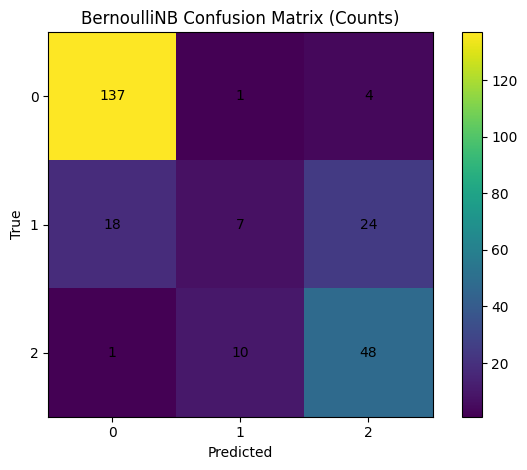

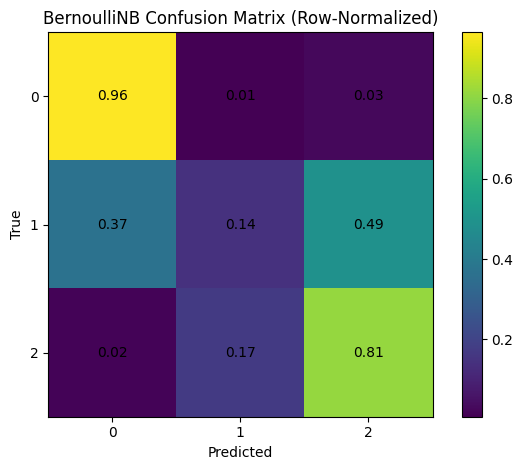


Top 20 binary indicators for class 0 (highest log P(x=1 | y=0)):
  type_traveller_NA                        -0.063
  cabin_flown_Economy                      -0.140
  aircraft_Other                           -1.061
  seat_layout_3x4x3                        -1.113
  seat_layout_2x4x2                        -1.150
  seat_layout_3x3                          -1.948
  cabin_flown_Premium Economy              -2.078
  seat_layout_3x3x3                        -2.243
  aircraft_BOEING 747-400                  -2.442
  seat_layout_Other                        -2.665
  aircraft_BOEING 777                      -2.691
  aircraft_AIRBUS A380                     -2.858
  seat_layout_2x3x2                        -2.987
  aircraft_BOEING 777-300ER                -3.059
  aircraft_BOEING 777-300                  -3.096
  aircraft_A340                            -3.219
  aircraft_B747-400                        -3.263
  aircraft_A330                            -3.310
  aircraft_Boeing 747-400         

In [10]:
import os
import csv
import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import accuracy_score, f1_score, log_loss, confusion_matrix, classification_report

BASE = "/content/drive/MyDrive/PR_Sky"
XTR_CSV = os.path.join(BASE, "X_train_bin.csv")
XTE_CSV = os.path.join(BASE, "X_test_bin.csv")
ytr_path = os.path.join(BASE, "y_train.csv")
yte_path = os.path.join(BASE, "y_test.csv")

feature_names = []
X_train_list = []
with open(XTR_CSV, "r", encoding="utf-8") as f:
    r = csv.reader(f)
    feature_names = next(r)
    for row in r:
        X_train_list.append([int(float(x)) for x in row])

X_test_list = []
with open(XTE_CSV, "r", encoding="utf-8") as f:
    r = csv.reader(f)
    test_header = next(r)
    if test_header != feature_names:
        missing_in_test = set(feature_names) - set(test_header)
        missing_in_train = set(test_header) - set(feature_names)
        if (len(missing_in_test) > 0) or (len(missing_in_train) > 0):
            raise ValueError(f"Column mismatch between train and test.\nMissing in test: {missing_in_test}\nMissing in train: {missing_in_train}")

        order = [test_header.index(col) for col in feature_names]
        for row in r:
            X_test_list.append([int(float(row[i])) for i in order])
    else:
        for row in r:
            X_test_list.append([int(float(x)) for x in row])

y_train = []
with open(ytr_path, "r", encoding="utf-8") as f:
    r = csv.reader(f)
    _ = next(r)
    for row in r:
        y_train.append(int(row[0]))

y_test = []
with open(yte_path, "r", encoding="utf-8") as f:
    r = csv.reader(f)
    _ = next(r)
    for row in r:
        y_test.append(int(row[0]))

X_train = np.array(X_train_list, dtype=np.int8)
X_test  = np.array(X_test_list, dtype=np.int8)
y_train = np.array(y_train, dtype=int)
y_test  = np.array(y_test, dtype=int)

print("X_train shape:", X_train.shape, " X_test shape:", X_test.shape)
print("Classes (train):", sorted(list(set(y_train.tolist()))))
print("Classes (test) :", sorted(list(set(y_test.tolist()))))

n_splits = 5
classes = sorted(list(set(y_train.tolist())))
by_class = {c: [] for c in classes}
i = 0
while i < len(y_train):
    by_class[y_train[i]].append(i)
    i += 1

folds = [list() for _ in range(n_splits)]
for c in classes:
    idxs = by_class[c]
    j = 0
    while j < len(idxs):
        folds[j % n_splits].append(idxs[j])
        j += 1

param_grid = [0.1, 0.5, 1.0, 2.0]
best_alpha = None
best_mean_neg_ll = None

print("\n=== Grid Search Results (neg_log_loss higher is better) ===")
i = 0
while i < len(param_grid):
    a = param_grid[i]
    fold_scores = []
    fi = 0
    while fi < n_splits:
        val_idx = folds[fi]
        train_idx = []
        fj = 0
        while fj < n_splits:
            if fj != fi:
                train_idx.extend(folds[fj])
            fj += 1

        Xt = X_train[train_idx]
        yt = y_train[train_idx]
        Xv = X_train[val_idx]
        yv = y_train[val_idx]

        clf = BernoulliNB(alpha=a)
        clf.fit(Xt, yt)
        proba = clf.predict_proba(Xv)
        ll = log_loss(yv, proba, labels=clf.classes_)
        fold_scores.append(-ll)
        fi += 1

    mean_score = float(np.mean(fold_scores)) if len(fold_scores) > 0 else float("-inf")
    std_score  = float(np.std(fold_scores))  if len(fold_scores) > 0 else 0.0
    print(f"{{'alpha': {a}}} -> mean neg_log_loss: {mean_score:.4f} (± {std_score:.4f})")

    if (best_mean_neg_ll is None) or (mean_score > best_mean_neg_ll):
        best_mean_neg_ll = mean_score
        best_alpha = a
    i += 1

best_bnb = BernoulliNB(alpha=best_alpha)
best_bnb.fit(X_train, y_train)
print("\nBest params:", {"alpha": best_alpha})

y_pred  = best_bnb.predict(X_test)
y_proba = best_bnb.predict_proba(X_test)

acc = accuracy_score(y_test, y_pred)
f1_macro = f1_score(y_test, y_pred, average="macro")
ll = log_loss(y_test, y_proba, labels=best_bnb.classes_)

classes_arr = best_bnb.classes_
class_to_idx = {}
k = 0
while k < len(classes_arr):
    class_to_idx[classes_arr[k]] = k
    k += 1

y_true_onehot = np.zeros_like(y_proba)
i = 0
while i < len(y_test):
    y_true_onehot[i, class_to_idx[y_test[i]]] = 1.0
    i += 1
brier_multiclass = float(np.mean((y_proba - y_true_onehot) ** 2))

print("\n=== BernoulliNB Metrics (Test) ===")
print(f"Accuracy          : {acc:.4f}")
print(f"Macro F1          : {f1_macro:.4f}")
print(f"Log-loss          : {ll:.4f}")
print(f"Brier (multiclass): {brier_multiclass:.6f}")

print("\n=== Classification Report ===")
print(classification_report(y_test, y_pred, digits=4))

cm = confusion_matrix(y_test, y_pred, labels=classes_arr)
print("\nConfusion Matrix (counts) [rows=true, cols=pred]:\n", cm)

plt.figure()
plt.imshow(cm, interpolation='nearest')
plt.title("BernoulliNB Confusion Matrix (Counts)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(range(len(classes_arr)), classes_arr)
plt.yticks(range(len(classes_arr)), classes_arr)
i = 0
while i < cm.shape[0]:
    j = 0
    while j < cm.shape[1]:
        plt.text(j, i, str(cm[i, j]), ha="center", va="center")
        j += 1
    i += 1
plt.colorbar()
plt.tight_layout()
plt.show()

cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)
plt.figure()
plt.imshow(cm_norm, interpolation='nearest')
plt.title("BernoulliNB Confusion Matrix (Row-Normalized)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(range(len(classes_arr)), classes_arr)
plt.yticks(range(len(classes_arr)), classes_arr)
i = 0
while i < cm_norm.shape[0]:
    j = 0
    while j < cm_norm.shape[1]:
        plt.text(j, i, f"{cm_norm[i, j]:.2f}", ha="center", va="center")
        j += 1
    i += 1
plt.colorbar()
plt.tight_layout()
plt.show()

log_prob = best_bnb.feature_log_prob_
top_k = 20

ci = 0
while ci < len(classes_arr):
    c = classes_arr[ci]
    scores = log_prob[ci]
    order = np.argsort(scores)[::-1][:top_k]
    print(f"\nTop {top_k} binary indicators for class {c} (highest log P(x=1 | y={c})):")
    oi = 0
    while oi < len(order):
        j = order[oi]
        fname = feature_names[j] if j < len(feature_names) else ("f" + str(j))
        print(f"  {fname:<40s} {scores[j]:.3f}")
        oi += 1
    ci += 1

# Path way to Hybrid Model: Combining structured numeric and text features

LOAD DATASETS — numeric + text

In [11]:
import os
import csv
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer

BASE = "/content/drive/MyDrive/PR_Sky"

train_num_path = os.path.join(BASE, "seat_train_proc.csv")
test_num_path  = os.path.join(BASE, "seat_test_proc.csv")
target_col_num = "satisfaction_class"

with open(train_num_path, "r", encoding="utf-8") as f:
    r = csv.DictReader(f)
    train_header = r.fieldnames
    num_features = [c for c in train_header if c != target_col_num]
    X_num_train_list = []
    y_num_train_list = []
    for row in r:
        vec = []
        for c in num_features:
            try:
                vec.append(float(row[c]))
            except:
                vec.append(0.0)
        X_num_train_list.append(vec)
        y_num_train_list.append(int(float(row[target_col_num])))

with open(test_num_path, "r", encoding="utf-8") as f:
    r = csv.DictReader(f)
    test_header = r.fieldnames
    X_num_test_list = []
    y_num_test_list = []
    for row in r:
        vec = []
        for c in num_features:
            try:
                vec.append(float(row[c]))
            except:
                vec.append(0.0)
        X_num_test_list.append(vec)
        y_num_test_list.append(int(float(row[target_col_num])))

X_num_train = np.array(X_num_train_list, dtype=float)
X_num_test  = np.array(X_num_test_list, dtype=float)
y_num_train = np.array(y_num_train_list, dtype=int)
y_num_test  = np.array(y_num_test_list, dtype=int)

print("=== Numeric data ===")
print("Train num shape:", (X_num_train.shape[0], X_num_train.shape[1]), " Test num shape:", (X_num_test.shape[0], X_num_test.shape[1]))
print("Train classes:", np.bincount(y_num_train))
print("Test  classes:", np.bincount(y_num_test))

train_txt_path = os.path.join(BASE, "seat_text_train_split.csv")
test_txt_path  = os.path.join(BASE, "seat_text_test_split.csv")
text_col   = "content"
target_col = "satisfaction_class"

X_text_train_raw = []
y_text_train_list = []
with open(train_txt_path, "r", encoding="utf-8") as f:
    r = csv.DictReader(f)
    hdr = r.fieldnames
    if text_col not in hdr or target_col not in hdr:
        raise SystemExit(0)
    for row in r:
        X_text_train_raw.append(str(row[text_col]))
        y_text_train_list.append(int(float(row[target_col])))

X_text_test_raw = []
y_text_test_list = []
with open(test_txt_path, "r", encoding="utf-8") as f:
    r = csv.DictReader(f)
    hdr = r.fieldnames
    if text_col not in hdr or target_col not in hdr:
        raise SystemExit(0)
    for row in r:
        X_text_test_raw.append(str(row[text_col]))
        y_text_test_list.append(int(float(row[target_col])))

y_text_train = np.array(y_text_train_list, dtype=int)
y_text_test  = np.array(y_text_test_list, dtype=int)

vectorizer = TfidfVectorizer(
    ngram_range=(1, 2),
    min_df=3,
    max_df=0.90,
    max_features=20000,
    lowercase=True
)
X_text_train = vectorizer.fit_transform(X_text_train_raw)
X_text_test  = vectorizer.transform(X_text_test_raw)

print("\n=== Text data (TF-IDF rebuilt) ===")
print("TF-IDF vocab size:", len(vectorizer.vocabulary_))
print("Train text shape:", (X_text_train.shape[0], X_text_train.shape[1]), " Test text shape:", (X_text_test.shape[0], X_text_test.shape[1]))
print("Train classes:", np.bincount(y_text_train))
print("Test  classes:", np.bincount(y_text_test))

same_train = (y_num_train == y_text_train).all()
same_test  = (y_num_test == y_text_test).all()
if not same_train:
    raise AssertionError("Train label mismatch between numeric and text splits!")
if not same_test:
    raise AssertionError("Test label mismatch between numeric and text splits!")
print("\nLabels aligned across numeric and text datasets")

=== Numeric data ===
Train num shape: (1007, 5)  Test num shape: (250, 5)
Train classes: [571 200 236]
Test  classes: [142  49  59]

=== Text data (TF-IDF rebuilt) ===
TF-IDF vocab size: 6699
Train text shape: (1007, 6699)  Test text shape: (250, 6699)
Train classes: [571 200 236]
Test  classes: [142  49  59]

Labels aligned across numeric and text datasets


GAUSSIAN NB


=== GaussianNB (Numeric) — Test Metrics ===
Accuracy : 0.8120
Macro F1 : 0.7682
Log-loss : 0.5288
Brier    : 0.094440

Classification Report:
              precision    recall  f1-score   support

           0     0.9313    0.8592    0.8938       142
           1     0.5172    0.6122    0.5607        49
           2     0.8361    0.8644    0.8500        59

    accuracy                         0.8120       250
   macro avg     0.7615    0.7786    0.7682       250
weighted avg     0.8277    0.8120    0.8182       250


Confusion Matrix (counts) [rows=true, cols=pred]:
 [[122  20   0]
 [  9  30  10]
 [  0   8  51]]


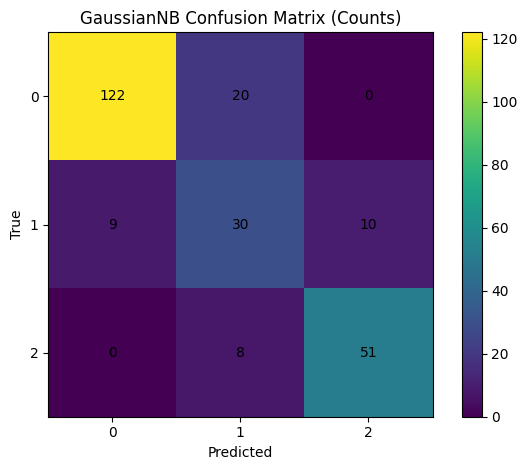


Saved: /content/drive/MyDrive/PR_Sky/P_gauss_test.npy and classes_gauss.npy


In [12]:
import os
import csv
import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, f1_score, log_loss, confusion_matrix, classification_report

BASE = "/content/drive/MyDrive/PR_Sky"
TRAIN_CSV = os.path.join(BASE, "seat_train_proc.csv")
TEST_CSV  = os.path.join(BASE, "seat_test_proc.csv")

target_col = "satisfaction_class"

with open(TRAIN_CSV, "r", encoding="utf-8") as f:
    r = csv.DictReader(f)
    train_header = r.fieldnames
    feat_cols = [c for c in train_header if c != target_col]
    X_train_list = []
    y_train_list = []
    for row in r:
        vec = []
        for c in feat_cols:
            try:
                vec.append(float(row[c]))
            except:
                vec.append(0.0)
        X_train_list.append(vec)
        y_train_list.append(int(float(row[target_col])))

with open(TEST_CSV, "r", encoding="utf-8") as f:
    r = csv.DictReader(f)
    X_test_list = []
    y_test_list = []
    for row in r:
        vec = []
        for c in feat_cols:
            try:
                vec.append(float(row[c]))
            except:
                vec.append(0.0)
        X_test_list.append(vec)
        y_test_list.append(int(float(row[target_col])))

X_train = np.array(X_train_list, dtype=float)
X_test  = np.array(X_test_list, dtype=float)
y_train = np.array(y_train_list, dtype=int)
y_test  = np.array(y_test_list, dtype=int)

gnb = GaussianNB()
gnb.fit(X_train, y_train)

y_pred  = gnb.predict(X_test)
y_proba = gnb.predict_proba(X_test)

acc = accuracy_score(y_test, y_pred)
f1m = f1_score(y_test, y_pred, average="macro")
ll  = log_loss(y_test, y_proba, labels=gnb.classes_)

Y = np.zeros_like(y_proba)
i = 0
while i < len(y_test):
    cls = y_test[i]

    j = 0
    col = 0
    while j < len(gnb.classes_):
        if gnb.classes_[j] == cls:
            col = j
            break
        j += 1
    Y[i, col] = 1.0
    i += 1
brier = float(np.mean((y_proba - Y) ** 2))

print("\n=== GaussianNB (Numeric) — Test Metrics ===")
print(f"Accuracy : {acc:.4f}")
print(f"Macro F1 : {f1m:.4f}")
print(f"Log-loss : {ll:.4f}")
print(f"Brier    : {brier:.6f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))

cm = confusion_matrix(y_test, y_pred, labels=gnb.classes_)
print("\nConfusion Matrix (counts) [rows=true, cols=pred]:\n", cm)

plt.figure()
plt.imshow(cm, interpolation='nearest'); plt.colorbar()
plt.title("GaussianNB Confusion Matrix (Counts)")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.xticks(range(len(gnb.classes_)), gnb.classes_)
plt.yticks(range(len(gnb.classes_)), gnb.classes_)
i = 0
while i < cm.shape[0]:
    j = 0
    while j < cm.shape[1]:
        plt.text(j, i, str(cm[i, j]), ha="center", va="center")
        j += 1
    i += 1
plt.tight_layout(); plt.show()

np.save(os.path.join(BASE, "P_gauss_test.npy"), y_proba)
np.save(os.path.join(BASE, "classes_gauss.npy"), gnb.classes_)
print("\nSaved:", os.path.join(BASE, "P_gauss_test.npy"), "and classes_gauss.npy")

MULTINOMIAL NB

Train size: 1007  Test size: 250
Class counts (train):
0 571
1 200
2 236
Class counts (test):
0 142
1 49
2 59
Word2Vec vocab size: 3021  dim: 200  -> Clustering K=109
BoC shapes -> Train: (1007, 109)  Test: (250, 109)

=== Grid Search (neg_log_loss higher is better) ===
{'alpha': 0.05} -> -1.3130 (± 0.1943)
{'alpha': 0.1} -> -1.3120 (± 0.1934)
{'alpha': 0.5} -> -1.3079 (± 0.1915)
{'alpha': 1.0} -> -1.3045 (± 0.1905)
{'alpha': 2.0} -> -1.2988 (± 0.1891)
Best params: {'alpha': 2.0}

=== MultinomialNB (Word2Vec BoC) — Test Metrics ===
Accuracy : 0.5560
Macro F1 : 0.4846
Log-loss : 1.3277
Brier    : 0.204095

Classification Report:
              precision    recall  f1-score   support

           0     0.7007    0.6761    0.6882       142
           1     0.3556    0.3265    0.3404        49
           2     0.3971    0.4576    0.4252        59

    accuracy                         0.5560       250
   macro avg     0.4844    0.4867    0.4846       250
weighted avg     0.5614    0.5560    0

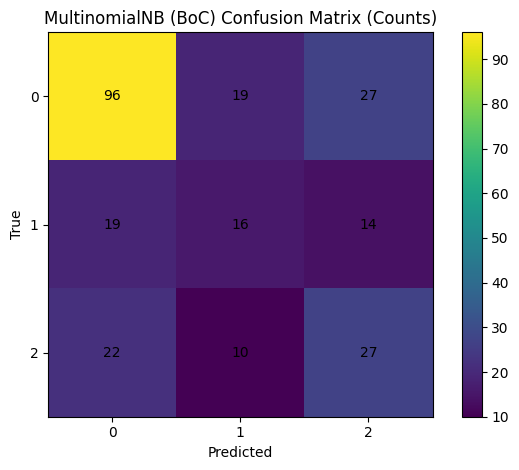

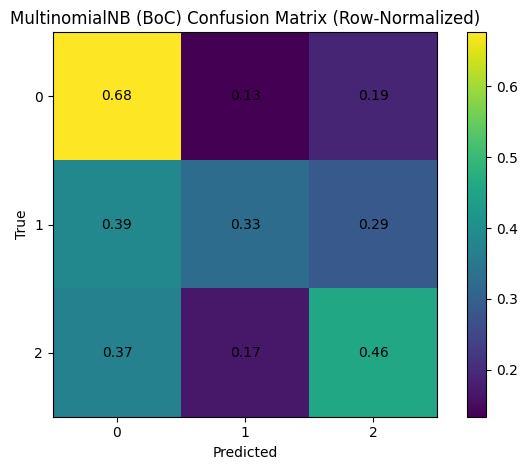


Saved .npy files:
  /content/drive/MyDrive/PR_Sky/P_text_test.npy
  /content/drive/MyDrive/PR_Sky/classes_text.npy


In [13]:
import os
import csv
import re
import math
import numpy as np
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
from sklearn.cluster import MiniBatchKMeans
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, f1_score, log_loss, confusion_matrix, classification_report

BASE = "/content/drive/MyDrive/PR_Sky"
TRAIN_SPLIT_CSV = os.path.join(BASE, "seat_text_train_split.csv")
TEST_SPLIT_CSV  = os.path.join(BASE, "seat_text_test_split.csv")

text_col = "content"
target_col = "satisfaction_class"

train_rows = []
with open(TRAIN_SPLIT_CSV, "r", encoding="utf-8") as f:
    r = csv.DictReader(f)
    train_hdr = r.fieldnames
    for row in r:
        train_rows.append(row)

test_rows = []
with open(TEST_SPLIT_CSV, "r", encoding="utf-8") as f:
    r = csv.DictReader(f)
    test_hdr = r.fieldnames
    for row in r:
        test_rows.append(row)

if (text_col not in train_hdr) or (target_col not in train_hdr):
    raise SystemExit(0)
if (text_col not in test_hdr) or (target_col not in test_hdr):
    raise SystemExit(0)

X_train_text = []
X_test_text  = []
y_train = []
y_test  = []

i = 0
while i < len(train_rows):
    X_train_text.append(str(train_rows[i][text_col]))
    y_train.append(int(float(train_rows[i][target_col])))
    i = i + 1

i = 0
while i < len(test_rows):
    X_test_text.append(str(test_rows[i][text_col]))
    y_test.append(int(float(test_rows[i][target_col])))
    i = i + 1

y_train = np.array(y_train, dtype=int)
y_test  = np.array(y_test, dtype=int)

print("Train size:", len(X_train_text), " Test size:", len(X_test_text))

c0 = c1 = c2 = 0
i = 0
while i < len(y_train):
    if y_train[i] == 0: c0 += 1
    elif y_train[i] == 1: c1 += 1
    elif y_train[i] == 2: c2 += 1
    i += 1
print("Class counts (train):")
print("0", c0); print("1", c1); print("2", c2)

c0 = c1 = c2 = 0
i = 0
while i < len(y_test):
    if y_test[i] == 0: c0 += 1
    elif y_test[i] == 1: c1 += 1
    elif y_test[i] == 2: c2 += 1
    i += 1
print("Class counts (test):")
print("0", c0); print("1", c1); print("2", c2)

token_pat = re.compile(r"[A-Za-z0-9]+")
tr_tokens = []
i = 0
while i < len(X_train_text):
    tr_tokens.append(token_pat.findall(X_train_text[i].lower()))
    i = i + 1

te_tokens = []
i = 0
while i < len(X_test_text):
    te_tokens.append(token_pat.findall(X_test_text[i].lower()))
    i = i + 1

w2v = Word2Vec(
    sentences=tr_tokens,
    vector_size=200,
    window=5,
    min_count=2,
    workers=4,
    sg=0,
    negative=10,
    epochs=10,
    seed=42
)

vocab_words = list(w2v.wv.key_to_index.keys())
if len(vocab_words) == 0:
    raise RuntimeError("Word2Vec vocab is empty; check min_count or training data.")

W = w2v.wv[vocab_words]
V = W.shape[0]
dim = W.shape[1]

rootV = math.sqrt(V)
K = int(rootV * 2.0)
if K < 100: K = 100
if K > 500: K = 500

print(f"Word2Vec vocab size: {V}  dim: {dim}  -> Clustering K={K}")

kmeans = MiniBatchKMeans(n_clusters=K, batch_size=2048, random_state=42, n_init=10)
kmeans.fit(W)

word_to_cluster = {}
i = 0
while i < len(vocab_words):
    word_to_cluster[vocab_words[i]] = int(kmeans.labels_[i])
    i = i + 1

X_train_boc = np.zeros((len(tr_tokens), K), dtype=np.float32)
i = 0
while i < len(tr_tokens):
    toks = tr_tokens[i]
    j = 0
    while j < len(toks):
        t = toks[j]
        cid = word_to_cluster.get(t, None)
        if cid is not None:
            X_train_boc[i, cid] = X_train_boc[i, cid] + 1.0
        j = j + 1
    i = i + 1

X_test_boc = np.zeros((len(te_tokens), K), dtype=np.float32)
i = 0
while i < len(te_tokens):
    toks = te_tokens[i]
    j = 0
    while j < len(toks):
        t = toks[j]
        cid = word_to_cluster.get(t, None)
        if cid is not None:
            X_test_boc[i, cid] = X_test_boc[i, cid] + 1.0
        j = j + 1
    i = i + 1

print("BoC shapes -> Train:", X_train_boc.shape, " Test:", X_test_boc.shape)

param_grid = [0.05, 0.1, 0.5, 1.0, 2.0]
n_splits = 5

classes = sorted(list(set(y_train.tolist())))
by_class = {c: [] for c in classes}
i = 0
while i < len(y_train):
    by_class[y_train[i]].append(i)
    i += 1

folds = [list() for _ in range(n_splits)]
for c in classes:
    idxs = by_class[c]
    j = 0
    while j < len(idxs):
        folds[j % n_splits].append(idxs[j])
        j += 1

best_alpha = None
best_mean_neg_ll = None
best_model = None

print("\n=== Grid Search (neg_log_loss higher is better) ===")
ai = 0
while ai < len(param_grid):
    a = param_grid[ai]
    scores = []
    fi = 0
    while fi < n_splits:
        val_idx = folds[fi]
        train_idx = []
        fj = 0
        while fj < n_splits:
            if fj != fi:
                train_idx.extend(folds[fj])
            fj += 1

        Xt = X_train_boc[train_idx]
        yt = y_train[train_idx]
        Xv = X_train_boc[val_idx]
        yv = y_train[val_idx]

        clf = MultinomialNB(alpha=a)
        clf.fit(Xt, yt)
        proba = clf.predict_proba(Xv)
        ll = log_loss(yv, proba, labels=clf.classes_)
        scores.append(-ll)
        fi += 1

    mean_score = float(np.mean(scores)) if len(scores) > 0 else float("-inf")
    std_score  = float(np.std(scores))  if len(scores) > 0 else 0.0
    print(f"{{'alpha': {a}}} -> {mean_score:.4f} (± {std_score:.4f})")

    if (best_mean_neg_ll is None) or (mean_score > best_mean_neg_ll):
        best_mean_neg_ll = mean_score
        best_alpha = a
    ai += 1

best_mnb = MultinomialNB(alpha=best_alpha)
best_mnb.fit(X_train_boc, y_train)
print("Best params:", {"alpha": best_alpha})

y_pred  = best_mnb.predict(X_test_boc)
y_proba = best_mnb.predict_proba(X_test_boc)

acc = accuracy_score(y_test, y_pred)
f1m = f1_score(y_test, y_pred, average="macro")
ll  = log_loss(y_test, y_proba, labels=best_mnb.classes_)

Y = np.zeros_like(y_proba)
class_index = {}
i = 0
while i < len(best_mnb.classes_):
    class_index[best_mnb.classes_[i]] = i
    i += 1
i = 0
while i < len(y_test):
    Y[i, class_index[y_test[i]]] = 1.0
    i += 1
brier = float(np.mean((y_proba - Y) ** 2))

print("\n=== MultinomialNB (Word2Vec BoC) — Test Metrics ===")
print(f"Accuracy : {acc:.4f}")
print(f"Macro F1 : {f1m:.4f}")
print(f"Log-loss : {ll:.4f}")
print(f"Brier    : {brier:.6f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))

cm = confusion_matrix(y_test, y_pred, labels=best_mnb.classes_)
print("\nConfusion Matrix (counts) [rows=true, cols=pred]:\n", cm)

plt.figure()
plt.imshow(cm, interpolation='nearest'); plt.colorbar()
plt.title("MultinomialNB (BoC) Confusion Matrix (Counts)")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.xticks(range(len(best_mnb.classes_)), best_mnb.classes_)
plt.yticks(range(len(best_mnb.classes_)), best_mnb.classes_)
i = 0
while i < cm.shape[0]:
    j = 0
    while j < cm.shape[1]:
        plt.text(j, i, str(cm[i, j]), ha="center", va="center")
        j += 1
    i += 1
plt.tight_layout(); plt.show()

cmn = cm.astype(float) / cm.sum(axis=1, keepdims=True)
plt.figure()
plt.imshow(cmn, interpolation='nearest'); plt.colorbar()
plt.title("MultinomialNB (BoC) Confusion Matrix (Row-Normalized)")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.xticks(range(len(best_mnb.classes_)), best_mnb.classes_)
plt.yticks(range(len(best_mnb.classes_)), best_mnb.classes_)
i = 0
while i < cmn.shape[0]:
    j = 0
    while j < cmn.shape[1]:
        plt.text(j, i, f"{cmn[i, j]:.2f}", ha="center", va="center")
        j += 1
    i += 1
plt.tight_layout(); plt.show()

np.save(os.path.join(BASE, "P_text_test.npy"), y_proba)
np.save(os.path.join(BASE, "classes_text.npy"), best_mnb.classes_)
print("\nSaved .npy files:")
print(" ", os.path.join(BASE, "P_text_test.npy"))
print(" ", os.path.join(BASE, "classes_text.npy"))

HYBRID — combine GaussianNB (numeric) + MultinomialNB (text)


=== Hybrid sweep (w * P_text + (1-w) * P_numeric) ===
 w_text  accuracy  macro_f1  log_loss     brier
   0.00    0.8120    0.7682    0.5288    0.0944
   0.25    0.8160    0.7726    0.5174    0.0922
   0.50    0.7800    0.7240    0.6005    0.1098
   0.60    0.7240    0.6624    0.6501    0.1223
   0.70    0.6560    0.5934    0.7131    0.1380
   0.75    0.6320    0.5662    0.7515    0.1471
   1.00    0.5560    0.4846    1.3277    0.2041

>> Best by log-loss: w_text=0.25 | acc=0.8160 | macro_f1=0.7726 | log_loss=0.5174 | brier=0.092232

Confusion Matrix (counts) [rows=true, cols=pred]:
 [[122  19   1]
 [  9  30  10]
 [  0   7  52]]


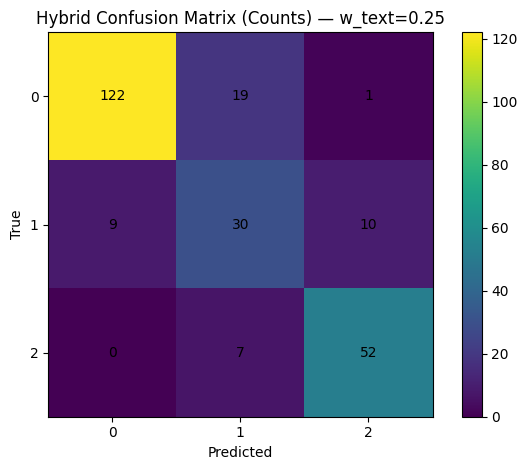


Classification Report (Hybrid):
              precision    recall  f1-score   support

           0     0.9313    0.8592    0.8938       142
           1     0.5357    0.6122    0.5714        49
           2     0.8254    0.8814    0.8525        59

    accuracy                         0.8160       250
   macro avg     0.7641    0.7843    0.7726       250
weighted avg     0.8288    0.8160    0.8208       250



In [14]:
import os
import csv
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, log_loss, confusion_matrix, classification_report

BASE = "/content/drive/MyDrive/PR_Sky"

P_g = np.load(os.path.join(BASE, "P_gauss_test.npy"))
Cg  = np.load(os.path.join(BASE, "classes_gauss.npy"))
P_t = np.load(os.path.join(BASE, "P_text_test.npy"))
Ct  = np.load(os.path.join(BASE, "classes_text.npy"))

y_test = []
with open(os.path.join(BASE, "y_test.csv"), "r", encoding="utf-8") as f:
    r = csv.reader(f)
    _ = next(r)
    for row in r:
        y_test.append(int(row[0]))
y_test = np.array(y_test, dtype=int)

u = sorted(set(Cg.tolist()) | set(Ct.tolist()))
classes = np.array(u, dtype=int)

def align_probs(P, classes_from, classes_to):
    out = np.zeros((P.shape[0], len(classes_to)), dtype=float)
    j = 0
    while j < len(classes_to):
        c = classes_to[j]

        k = 0
        found = -1
        while k < len(classes_from):
            if int(classes_from[k]) == int(c):
                found = k
                break
            k += 1
        if found >= 0:
            out[:, j] = P[:, found]
        else:
            out[:, j] = 1e-9
        j += 1

    i = 0
    while i < out.shape[0]:
        s = float(out[i].sum())
        if s == 0.0:
            s = 1.0
        out[i] = out[i] / s
        i += 1
    return out

P_g_aligned = align_probs(P_g, Cg, classes)
P_t_aligned = align_probs(P_t, Ct, classes)

weights = [0.0, 0.25, 0.5, 0.6, 0.7, 0.75, 1.0]
rows = []
best_idx = None
best_ll = float("inf")

i = 0
while i < len(weights):
    w = float(weights[i])
    P_h = w * P_t_aligned + (1.0 - w) * P_g_aligned

    y_pred = []
    r = 0
    while r < P_h.shape[0]:
        row = P_h[r]
        mi = 0
        k = 1
        while k < len(row):
            if row[k] > row[mi]:
                mi = k
            k += 1
        y_pred.append(int(classes[mi]))
        r += 1
    y_pred = np.array(y_pred, dtype=int)

    acc = accuracy_score(y_test, y_pred)
    f1m = f1_score(y_test, y_pred, average="macro")
    ll  = log_loss(y_test, P_h, labels=classes)

    Y = np.zeros_like(P_h)
    class_to_idx = {}
    j = 0
    while j < len(classes):
        class_to_idx[int(classes[j])] = j
        j += 1
    r = 0
    while r < len(y_test):
        Y[r, class_to_idx[int(y_test[r])]] = 1.0
        r += 1
    brier = float(np.mean((P_h - Y) ** 2))

    rows.append({"w_text": w, "accuracy": acc, "macro_f1": f1m, "log_loss": ll, "brier": brier})

    if ll < best_ll:
        best_ll = ll
        best_idx = len(rows) - 1
    i += 1

print("\n=== Hybrid sweep (w * P_text + (1-w) * P_numeric) ===")

print(f"{'w_text':>7}  {'accuracy':>8}  {'macro_f1':>8}  {'log_loss':>8}  {'brier':>8}")
ri = 0
while ri < len(rows):
    r = rows[ri]
    print(f"{r['w_text']:7.2f}  {r['accuracy']:8.4f}  {r['macro_f1']:8.4f}  {r['log_loss']:8.4f}  {r['brier']:8.4f}")
    ri += 1

best = rows[best_idx]
w = float(best["w_text"])
print(f"\n>> Best by log-loss: w_text={w:.2f} | acc={best['accuracy']:.4f} | macro_f1={best['macro_f1']:.4f} | log_loss={best['log_loss']:.4f} | brier={best['brier']:.6f}")

P_h = w * P_t_aligned + (1.0 - w) * P_g_aligned

y_pred = []
r = 0
while r < P_h.shape[0]:
    row = P_h[r]
    mi = 0
    k = 1
    while k < len(row):
        if row[k] > row[mi]:
            mi = k
        k += 1
    y_pred.append(int(classes[mi]))
    r += 1
y_pred = np.array(y_pred, dtype=int)

cm = confusion_matrix(y_test, y_pred, labels=classes)
print("\nConfusion Matrix (counts) [rows=true, cols=pred]:\n", cm)

plt.figure()
plt.imshow(cm, interpolation='nearest'); plt.colorbar()
plt.title(f"Hybrid Confusion Matrix (Counts) — w_text={w:.2f}")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.xticks(range(len(classes)), classes)
plt.yticks(range(len(classes)), classes)
i = 0
while i < cm.shape[0]:
    j = 0
    while j < cm.shape[1]:
        plt.text(j, i, str(cm[i, j]), ha="center", va="center")
        j += 1
    i += 1
plt.tight_layout(); plt.show()

print("\nClassification Report (Hybrid):")
print(classification_report(y_test, y_pred, digits=4))